In [1]:
import sys

# Now get necessary libraries

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
import tensorflow as tf
import skimage

from libs import utils, gif
import IPython.display as ipyd

%matplotlib inline
plt.style.use('ggplot')

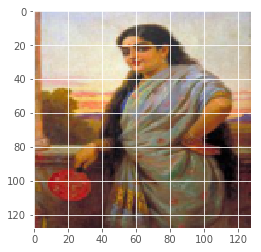

In [2]:
# prepare train images, each image to have same size
# be sure to look for png image with transparent channel
# and save it as jpeg image, otherwise you will run into
# dimensional problem for np array broadcasting
index = 1
imgs = []
for image in os.listdir("./ravi varma paintings/"):
    # open image
    img = skimage.io.imread('./ravi varma paintings/'+image)
    img = imresize(img, (128, 128))
    imgs.append(img)
    plt.imsave(fname='./train/' + str(index) +'.png', arr=img)
    index += 1
    plt.imshow(img)

In [3]:
def split_image(img):
    # We'll first collect all the positions in the image in our list, xs
    xs = []

    # And the corresponding colors for each of these positions
    ys = []

    # Now loop over the image
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            # And store the inputs
            xs.append([row_i, col_i])
            # And outputs that the network needs to learn to predict
            ys.append(img[row_i, col_i])

    # we'll convert our lists to arrays
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

In [4]:
def build_model(xs, ys, n_neurons, n_layers, activation_fn,
                final_activation_fn, cost_type):
    
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    if xs.ndim != 2:
        raise ValueError(
            'xs should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
    if ys.ndim != 2:
        raise ValueError(
            'ys should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
        
    n_xs = xs.shape[1]
    n_ys = ys.shape[1]
    
    X = tf.placeholder(name='X', shape=[None, n_xs],
                       dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape=[None, n_ys],
                       dtype=tf.float32)

    current_input = X
    for layer_i in range(n_layers):
        current_input = utils.linear(
            current_input, n_neurons,
            activation=activation_fn,
            name='layer{}'.format(layer_i))[0]

    Y_pred = utils.linear(
        current_input, n_ys,
        activation=final_activation_fn,
        name='pred')[0]
    
    if cost_type == 'l1_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.abs(Y - Y_pred), 1))
    elif cost_type == 'l2_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.squared_difference(Y, Y_pred), 1))
    else:
        raise ValueError(
            'Unknown cost_type: {}.  '.format(
            cost_type) + 'Use only "l1_norm" or "l2_norm"')
    
    return {'X': X, 'Y': Y, 'Y_pred': Y_pred, 'cost': cost}

In [5]:
def train(imgs,
          learning_rate=0.0001,
          batch_size=200,
          n_iterations=10,
          gif_step=2,
          n_neurons=30,
          n_layers=10,
          activation_fn=tf.nn.relu,
          final_activation_fn=tf.nn.tanh,
          cost_type='l2_norm'):

    N, H, W, C = imgs.shape
    all_xs, all_ys = [], []
    for img_i, img in enumerate(imgs):
        xs, ys = split_image(img)
        all_xs.append(np.c_[xs, np.repeat(img_i, [xs.shape[0]])])
        all_ys.append(ys)
    xs = np.array(all_xs).reshape(-1, 3)
    xs = (xs - np.mean(xs, 0)) / np.std(xs, 0)
    ys = np.array(all_ys).reshape(-1, 3)
    ys = ys / 127.5 - 1

    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        model = build_model(xs, ys, n_neurons, n_layers,
                            activation_fn, final_activation_fn,
                            cost_type)
        optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(model['cost'])
        sess.run(tf.global_variables_initializer())
        gifs = []
        costs = []
        step_i = 0
        for it_i in range(n_iterations):
            # Get a random sampling of the dataset
            idxs = np.random.permutation(range(len(xs)))

            # The number of batches we have to iterate over
            n_batches = len(idxs) // batch_size
            training_cost = 0

            # Now iterate over our stochastic minibatches:
            for batch_i in range(n_batches):

                # Get just minibatch amount of data
                idxs_i = idxs[batch_i * batch_size:
                              (batch_i + 1) * batch_size]

                # And optimize, also returning the cost so we can monitor
                # how our optimization is doing.
                cost = sess.run(
                    [model['cost'], optimizer],
                    feed_dict={model['X']: xs[idxs_i],
                               model['Y']: ys[idxs_i]})[0]
                training_cost += cost

            print('iteration {}/{}: cost {}'.format(
                    it_i + 1, n_iterations, training_cost / n_batches))

            # Also, every 20 iterations, we'll draw the prediction of our
            # input xs, which should try to recreate our image!
            if (it_i + 1) % gif_step == 0:
                costs.append(training_cost / n_batches)
                ys_pred = model['Y_pred'].eval(
                    feed_dict={model['X']: xs}, session=sess)
                img = ys_pred.reshape(imgs.shape)
                gifs.append(img)
        return gifs

In [6]:
print(type(imgs))
len(imgs), len(imgs[0]), len(imgs[0][0]), len(imgs[0][0][0])

<class 'list'>


(45, 128, 128, 3)

In [7]:
imgs = np.array(imgs)

In [8]:
gifs = train(imgs=imgs, n_iterations=10, gif_step=1)

iteration 1/10: cost 0.6268951029426303
iteration 2/10: cost 0.5759412684698695
iteration 3/10: cost 0.5556821828860662
iteration 4/10: cost 0.5424303069379235
iteration 5/10: cost 0.528597988386356
iteration 6/10: cost 0.5159702867237175
iteration 7/10: cost 0.5031170867023685
iteration 8/10: cost 0.49178494120899
iteration 9/10: cost 0.48209523659035747
iteration 10/10: cost 0.4735921310767232


In [9]:
import imageio

# Save the images as a GIF
def build_gif(imgs, saveto):
    kargs = { 'duration': 0.5 }
    imageio.mimsave(saveto, imgs, 'GIF', **kargs)

In [10]:
def build_movie(imgs, saveto):
    with imageio.get_writer(saveto, mode='I') as writer:
        for img in imgs:
            writer.append_data(img)

In [11]:
n = len(gifs)
build_gif(gifs[n-1], saveto='raviverma-paintings.gif')

C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.7084693312644958, 0.8511724472045898]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.5613451600074768, 0.8414632081985474]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.5699278116226196, 0.5851062536239624]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.5769203305244446, 0.6065971255302429]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [12]:
import imageio
ipyd.Image(url='raviverma-paintings.gif?{}'.format(np.random.rand()),
           height=500, width=500)

In [15]:
gifs = train(imgs=imgs, n_iterations=50, gif_step=1)

iteration 1/50: cost 0.6319498791280028
iteration 2/50: cost 0.6037134867094809
iteration 3/50: cost 0.5828734885656633
iteration 4/50: cost 0.5695348457674325
iteration 5/50: cost 0.5594088954651931
iteration 6/50: cost 0.5516848065609914
iteration 7/50: cost 0.5437383327190474
iteration 8/50: cost 0.5347944015047825
iteration 9/50: cost 0.5256711217335754
iteration 10/50: cost 0.5170395169417236
iteration 11/50: cost 0.5076381846882375
iteration 12/50: cost 0.4979664532794166
iteration 13/50: cost 0.4886099747824268
iteration 14/50: cost 0.47909427099879903
iteration 15/50: cost 0.46832753273209216
iteration 16/50: cost 0.45634886185824064
iteration 17/50: cost 0.4447792765810253
iteration 18/50: cost 0.43442401154915794
iteration 19/50: cost 0.42400093204420153
iteration 20/50: cost 0.4144273588936159
iteration 21/50: cost 0.40575674370262715
iteration 22/50: cost 0.3985852095916487
iteration 23/50: cost 0.39167606138497413
iteration 24/50: cost 0.386009920228776
iteration 25/50: co

In [16]:
n = len(gifs)
build_gif(gifs[n-1], saveto='raviverma-paintings_'+ str(n) + '_epoch_.gif')

C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.7916935086250305, 0.8837851285934448]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.8716796040534973, 0.951926052570343]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.8600086569786072, 0.11958075314760208]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.7162168622016907, 0.8340883255004883]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [17]:
ipyd.Image(url='raviverma-paintings_50_epoch_.gif?{}'.format(np.random.rand()),
           height=500, width=500)

In [18]:
gifs = train(imgs=imgs, n_iterations=75, gif_step=1)

iteration 1/75: cost 0.6282417115978229
iteration 2/75: cost 0.587056865874219
iteration 3/75: cost 0.5659456764930496
iteration 4/75: cost 0.5495695488419277
iteration 5/75: cost 0.5350608062029403
iteration 6/75: cost 0.5212753260193864
iteration 7/75: cost 0.5101219726058367
iteration 8/75: cost 0.4986278150984598
iteration 9/75: cost 0.4869218469959721
iteration 10/75: cost 0.4757219534721054
iteration 11/75: cost 0.46471126997723117
iteration 12/75: cost 0.4556132754067397
iteration 13/75: cost 0.4459660480317381
iteration 14/75: cost 0.43677271876688306
iteration 15/75: cost 0.42769242531245516
iteration 16/75: cost 0.41809915077311155
iteration 17/75: cost 0.4094489436158006
iteration 18/75: cost 0.40105306643768296
iteration 19/75: cost 0.39395619708108826
iteration 20/75: cost 0.38693931305854784
iteration 21/75: cost 0.38037830004210843
iteration 22/75: cost 0.37464032561896743
iteration 23/75: cost 0.36956312913676026
iteration 24/75: cost 0.3647042880045999
iteration 25/75:

In [19]:
n = len(gifs)
build_gif(gifs[n-1], saveto='raviverma-paintings_'+ str(n) + '_epoch_.gif')

C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.7662420272827148, 0.9627518653869629]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.9172087907791138, 0.9317970871925354]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.9017725586891174, 0.7155032157897949]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.7424217462539673, 0.8844678401947021]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [20]:
ipyd.Image(url='raviverma-paintings_75_epoch_.gif?{}'.format(np.random.rand()),
           height=500, width=500)

In [21]:
gifs = train(imgs=imgs, n_iterations=150, gif_step=1)

iteration 1/150: cost 0.632669957238439
iteration 2/150: cost 0.6014752754586842
iteration 3/150: cost 0.5794433626188122
iteration 4/150: cost 0.5612150946358139
iteration 5/150: cost 0.5402095267792726
iteration 6/150: cost 0.5215894812096479
iteration 7/150: cost 0.5075412449455753
iteration 8/150: cost 0.494003197621924
iteration 9/150: cost 0.4793084517760052
iteration 10/150: cost 0.4654172151892714
iteration 11/150: cost 0.45242783684350196
iteration 12/150: cost 0.44082745026778863
iteration 13/150: cost 0.43042596522162807
iteration 14/150: cost 0.4207711405425504
iteration 15/150: cost 0.4116498844023962
iteration 16/150: cost 0.40325892848840433
iteration 17/150: cost 0.39648088261412334
iteration 18/150: cost 0.39072191649749755
iteration 19/150: cost 0.3845337571751082
iteration 20/150: cost 0.3798382667277859
iteration 21/150: cost 0.3750097042296286
iteration 22/150: cost 0.37055830659099204
iteration 23/150: cost 0.3663939547179771
iteration 24/150: cost 0.3627653876304

In [22]:
n = len(gifs)
build_gif(gifs[n-1], saveto='raviverma-paintings_'+ str(n) + '_epoch_.gif')

C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.8636565208435059, 0.8898136615753174]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.9485575556755066, 0.9135432243347168]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.9255611896514893, 0.4217722713947296]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.6195451021194458, 0.8194692730903625]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [23]:
ipyd.Image(url='raviverma-paintings_150_epoch_.gif'.format(np.random.rand()),
           height=500, width=500)

####  Lets try bigger network - more neurons and layers

In [25]:
gifs = train(imgs,
        learning_rate=0.001,
        n_iterations=30,
        gif_step=2,
        n_neurons=50,
        n_layers=20,
        activation_fn=tf.nn.relu,
        final_activation_fn=tf.nn.tanh,
        cost_type='l2_norm')

iteration 1/30: cost 0.5457758665149521
iteration 2/30: cost 0.368643978583347
iteration 3/30: cost 0.30472356169138404
iteration 4/30: cost 0.2674583016176684
iteration 5/30: cost 0.24606262244854166
iteration 6/30: cost 0.22632030337418282
iteration 7/30: cost 0.2160366042858223
iteration 8/30: cost 0.20637411865336508
iteration 9/30: cost 0.20077410710816854
iteration 10/30: cost 0.19407509464004477
iteration 11/30: cost 0.18694121191885507
iteration 12/30: cost 0.19014182275669508
iteration 13/30: cost 0.23476535519681027
iteration 14/30: cost 0.20221102083676934
iteration 15/30: cost 0.1924951590569331
iteration 16/30: cost 0.18518493445797324
iteration 17/30: cost 0.18172707389868348
iteration 18/30: cost 0.17533786438013377
iteration 19/30: cost 0.1743601618281086
iteration 20/30: cost 0.17285973485710823
iteration 21/30: cost 0.17185387318540513
iteration 22/30: cost 0.16760829054890478
iteration 23/30: cost 0.17462027889923498
iteration 24/30: cost 0.16589344392125852
iteratio

In [28]:
n = len(gifs)
build_gif(gifs[n-1], saveto='bigger_network_raviverma-paintings_'+ str(n) + '_epoch_.gif')

C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.8649705052375793, 0.9505643844604492]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.936992347240448, 0.8872755765914917]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.9093590378761292, 0.34506669640541077]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\ravindra\Anaconda2\envs\tensorflow\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.7192082405090332, 0.8473869562149048]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [29]:
ipyd.Image(url='bigger_network_raviverma-paintings_15_epoch_.gif'.format(np.random.rand()),
           height=500, width=500)

In [30]:
gifs = train(imgs,
        learning_rate=0.001,
        n_iterations=30,
        gif_step=2,
        n_neurons=50,
        n_layers=40,
        activation_fn=tf.nn.relu,
        final_activation_fn=tf.nn.tanh,
        cost_type='l2_norm')

iteration 1/30: cost 0.6224372983949054
iteration 2/30: cost 0.5523680669987777
iteration 3/30: cost 0.4685613124899675
iteration 4/30: cost 0.3986770582551615
iteration 5/30: cost 0.3579187021427548
iteration 6/30: cost 0.32158363742296037
iteration 7/30: cost 0.29915285846233625
iteration 8/30: cost 0.3138821935134612
iteration 9/30: cost 0.368752031992844
iteration 10/30: cost 0.3707680094277671
iteration 11/30: cost 0.28432861295929435
iteration 12/30: cost 0.2847845983477759
iteration 13/30: cost 0.3465037552303292
iteration 14/30: cost 0.37118257663444665
iteration 15/30: cost 0.30315036285411906
iteration 16/30: cost 0.2843957612583059
iteration 17/30: cost 0.2867752160195805
iteration 18/30: cost 0.27744928055720297
iteration 19/30: cost 0.27041868834765914
iteration 20/30: cost 0.299233985885905
iteration 21/30: cost 0.27229573830307274
iteration 22/30: cost 0.28723486008378263
iteration 23/30: cost 0.2854214905641419
iteration 24/30: cost 0.27424060904617487
iteration 25/30: 